In [816]:
import os
import pandas as pd
import numpy as np
import sys
from sklearn.utils import shuffle

In [817]:
head = [
    'Page Popularity', 
    'Page Checkins',
    'Page talking about',
    'Page Category'    
] + ['extra_{}'.format(i - 4) for i in range(4, 29)] + \
[
    'CC1',
    'CC2',
    'CC3',
    'CC4',
    'CC5',
    'Base Time',
    'Post Length',
    'Post Share Count',
    'Post Promotion Status',
    'H Local'
] + ['published_weekday_{}'.format(i - 39) for i in range(39, 46)] + ['base_weekday_{}'.format(i-45) for i in range(45, 52)] + ['Target']

In [818]:
train_dataset_small = pd.read_csv('./Training/Features_Variant_1.csv', names=head)

\begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} &=& \frac{\partial}{\partial \vec{w}} \frac{1}{2n} \left( \vec{y}^T \vec{y} -2\vec{y}^T X \vec{w} + \vec{w}^T X^T X \vec{w}\right) \\ &=& \frac{1}{2n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right) \end{array}

In [911]:
def RMSE_score(y_pred, y_real):
    return np.sqrt(np.sum(np.power(y_pred - y_real, 2)) / y_pred.shape[0])

def R2_score(y_pred, y_real):
    return 1 - np.sum(np.power(y_pred - y_real, 2)) / np.sum(np.power(y_real - np.mean(y_real), 2))

def R2_adj_score(y_pred, y_real, features):
    R2 = R2_score(y_pred, y_real)
    return 1 - (1 - R2) * (y_real.shape[0] - 1) / (y_real.shape[0] - features - 1)

class LinearModel(object):
    def __init__(self, batches=1, epochs=5, use_constant=True):
        self.use_constant = use_constant
        self.batches = batches
        self.epochs = epochs
        self.w = None
    
    def fit(self, X, y):
        if self.use_constant:
            self.w = np.random.normal(size=X.shape[1] + 1, scale=0.1)
            X = np.hstack([X, np.array([1] * X.shape[0]).reshape(-1, 1)])
        else:
            self.w = np.random.normal(size=X.shape[1])
        
        n = X.shape[0]
        batch_size = n // self.batches
        
        for epoch in range(1, self.epochs + 1):
            for batch in range(self.batches):
                X_batch = X[batch * batch_size:(batch+1) * batch_size]
                y_batch = y[batch * batch_size:(batch+1) * batch_size]
        
                dw = X_batch.T.dot(X_batch).dot(self.w) - X_batch.T.dot(y_batch)
                self.w = self.w - dw * .0001 / np.log2(epoch + 1)
            
    
    def predict(self, X, y=None):
        if self.use_constant:
            X = np.hstack([X, np.array([1] * X.shape[0]).reshape(-1, 1)])
        return X.dot(self.w)

# функции для определения типа переменных

In [820]:
def is_float(x):
    return (x - x.astype(int)).abs().sum() > 0

def is_binary(x):
    return x.unique().shape[0] == 2

def is_unary(x):
    return x.unique().shape[0] == 1

# определение типа переменных и трансформации

In [821]:
pd.DataFrame({
    'вещественная': train_dataset_small.apply(is_float, axis=0), 
    'бинарная': train_dataset_small.apply(is_binary, axis=0),
    'константная': train_dataset_small.apply(is_unary, axis=0)
})

,бинарная,вещественная,константная
Page Popularity,False,False,False
Page Checkins,False,False,False
Page talking about,False,False,False
Page Category,False,False,False
extra_0,False,False,False
extra_1,False,False,False
extra_2,False,True,False
extra_3,False,True,False
extra_4,False,True,False
extra_5,False,False,False


# делаем копию датасета

In [891]:
train_dataset_small = train_dataset_small[
    (train_dataset_small.Target > train_dataset_small.Target.quantile(0.02)) & (train_dataset_small.Target < train_dataset_small.Target.quantile(.98))
].dropna()

In [941]:
from copy import deepcopy as copy
from matplotlib import pyplot

train_dataset_small_new = copy(train_dataset_small)

# удаляем лишние переменные

In [942]:
# удаляем лишний параметр для устранения мультиколлинеарности
train_dataset_small_new = train_dataset_small_new.drop(['published_weekday_0', 'base_weekday_0'], axis=1)

In [943]:
train_dataset_small_new = train_dataset_small_new.drop(['Post Promotion Status'], axis=1)

In [944]:
# меняем категориальную переменную на дамми-переменные
train_dataset_small_new = train_dataset_small_new.drop('Page Category', axis=1)
Page_Category = pd.get_dummies(train_dataset_small['Page Category'])
Page_Category = Page_Category.rename(columns={x: 'Page_Category_%d' % x for x in Page_Category.columns})
train_dataset_small_new = pd.concat([train_dataset_small_new, Page_Category], axis=1)

# проверяем, какие из экстра фичей коррелируют друг с другом

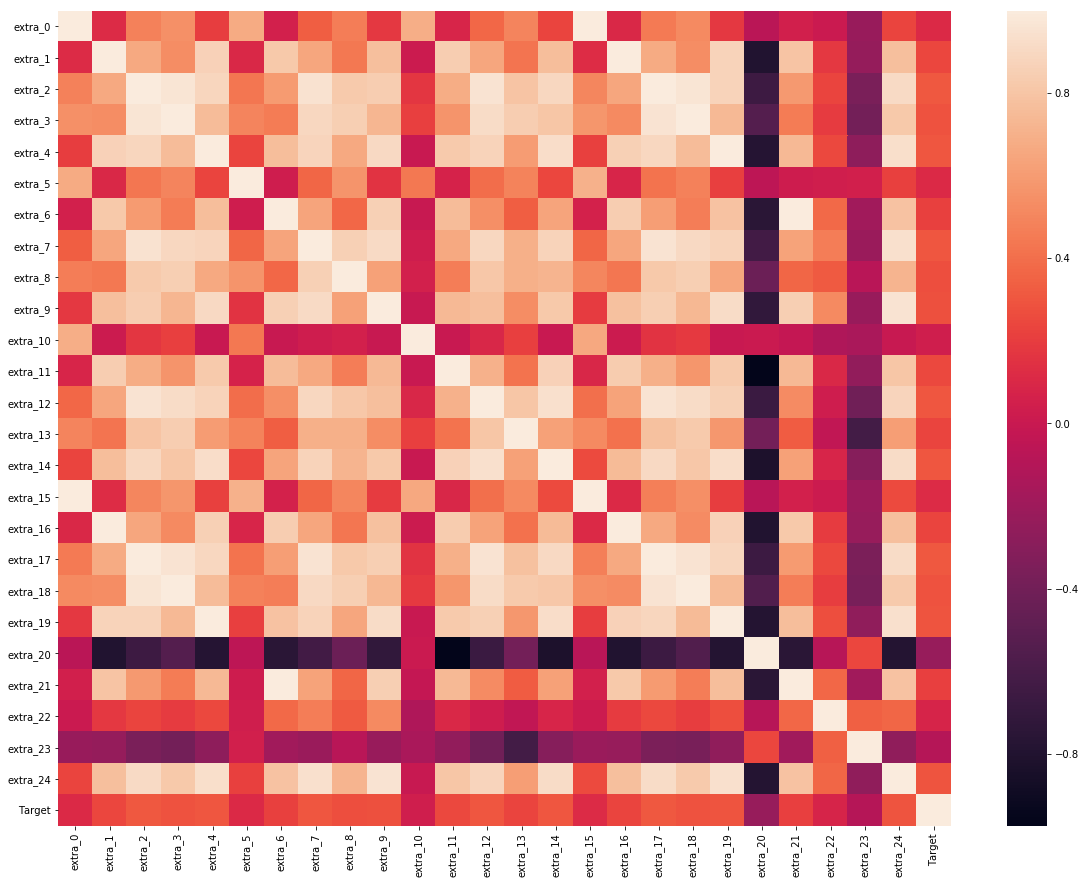

In [945]:
pyplot.figure(figsize=(20, 15))
sns.heatmap(train_dataset_small_new[['extra_{}'.format(i) for i in range(0, 25)] + ['Target']].corr())

In [946]:
# удаляем почти все переменные
train_dataset_small_new = train_dataset_small_new.drop(['extra_20', 'extra_23', 'extra_24', 'extra_21', 'extra_0','extra_8', 'extra_19', 'extra_18', 'extra_17', 'extra_9', 'extra_4', 'extra_14',
      'extra_12',  'extra_1', 'extra_6','extra_7', 'extra_2', 'extra_11', 'extra_16', 'extra_15', 'extra_5', 'extra_10', 'extra_13'], axis=1)

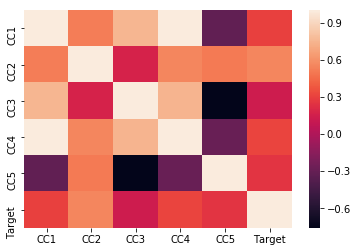

In [947]:
sns.heatmap(train_dataset_small[['CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Target']].corr())


In [948]:
# удаляем часть переменных
train_dataset_small_new = train_dataset_small_new.drop(['CC1', 'CC3', 'CC4',], axis=1)

In [949]:
# удаляем переменную Base Time, поскольку для нее сложно придумать адекватное представление

#train_dataset_small_new = train_dataset_small_new.drop('Base Time', axis=1)

In [950]:
#train_dataset_small_new = train_dataset_small_new.drop('Page talking about', axis=1)

In [951]:
# дамми кодинг переменной "время"

train_dataset_small_new = train_dataset_small_new.drop('H Local', axis=1)

HLocal = pd.get_dummies(train_dataset_small['H Local'])
HLocal = HLocal.rename(columns={x: 'H_Local_%d' % x for x in HLocal.columns})

train_dataset_small_new = pd.concat([train_dataset_small_new, HLocal], axis=1)

In [952]:
X = copy(train_dataset_small_new).dropna()

In [953]:
y = X['Target']
X = X.drop('Target', axis=1)

In [954]:
X, y = shuffle(X, y)

In [955]:
# получаем список не-бинарных переменных
not_binary_cols = X.columns[~X.apply(is_binary)]
print(not_binary_cols)
# выполняем нормировку не-биинарных переменных
X[not_binary_cols] = X[not_binary_cols].apply(lambda x: (x - x.mean()) / (x.std()), axis=0)

Index(['Page Popularity', 'Page Checkins', 'Page talking about', 'extra_3',
       'extra_22', 'CC2', 'CC5', 'Base Time', 'Post Length',
       'Post Share Count'],
      dtype='object')


In [956]:
def get_folds(X, batches=8, seed=42):
    indices = list(range(X.shape[0]))
    batch_size = X.shape[0] // batches
    for batch in range(batches):
        test = indices[batch_size*batch:batch_size*(batch+1)]
        if batch:
            train = indices[:batch_size*batch] + indices[batch_size*(batch+1):]
        else:
            train = indices[batch_size*(batch+1):]
            
        yield (train, test)

In [957]:
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []
r2_adj_train = []
r2_adj_test = []
features = []
features_names = []

for ix_train, ix_test in get_folds(X, 5):
    mdl = LinearModel(batches=10, epochs=100)
    mdl.fit(X.iloc[ix_train], y.iloc[ix_train])
    
    rmse_test.append(RMSE_score(mdl.predict(X.iloc[ix_test]), y.iloc[ix_test]))
    r2_test.append(R2_score(mdl.predict(X.iloc[ix_test]), y.iloc[ix_test]))
    r2_adj_test.append(R2_adj_score(mdl.predict(X.iloc[ix_test]), y.iloc[ix_test], X.columns.shape[0]))
    
    rmse_train.append(RMSE_score(mdl.predict(X.iloc[ix_train]), y.iloc[ix_train]))
    r2_train.append(R2_score(mdl.predict(X.iloc[ix_train]), y.iloc[ix_train]))
    r2_adj_train.append(R2_adj_score(mdl.predict(X.iloc[ix_train]), y.iloc[ix_train], X.columns.shape[0]))
    
    features.append(sorted(mdl.w, key=lambda x: -x)[:5])

In [958]:
df = pd.DataFrame(np.vstack([r2_test, r2_train, r2_adj_test, r2_adj_train, rmse_test, rmse_train, np.array(features).T]), index=[
    'r2_test',
    'r2_train',
    'r2_adj_test',
    'r2_adj_train',
    'rmse_test',
    'rmse_train',
] + ['f%d' % i for i in range(1, 6)], columns=['T%d' % i for i in range(1, 6)])

pd.concat([df, df.mean(axis=1).rename('mean'), df.std(axis=1).rename('std')], axis=1)

,T1,T2,T3,T4,T5,mean,std
r2_test,0.409279,0.362998,0.421069,0.385549,0.421670,0.400113,0.025384
r2_train,0.404035,0.413774,0.401464,0.409610,0.400308,0.405838,0.005705
r2_adj_test,0.387814,0.339852,0.400032,0.363222,0.400655,0.378315,0.026307
r2_adj_train,0.398767,0.408592,0.396174,0.404392,0.395007,0.400586,0.005755
rmse_test,9.906885,10.055568,9.602638,9.557607,9.675623,9.759664,0.213179
rmse_train,9.682882,9.659777,9.756507,9.770008,9.745956,9.723026,0.048647
f1,5.847961,6.429299,5.927501,5.998356,5.647096,5.970042,0.288412
f2,3.636600,3.685699,3.611283,3.595950,3.651381,3.636183,0.035077
f3,3.473512,3.462826,3.401403,3.534274,3.428179,3.460039,0.050382
f4,1.989901,1.794495,1.950581,1.938352,2.115547,1.957775,0.115123
